In [1]:
# based on https://www.youtube.com/watch?v=VMj-3S1tku0

In [2]:
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Создадим класс, который будет представлять собой число

In [4]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

In [5]:
a = Value(2.0)
a

Value(data=2.0)

In [6]:
# Добавим в этот класс возможность математических операций

In [7]:
class Value:
    def __init__(self, data):
        self.data = data

    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        return Value(self.data+other.data)

    def __repr__(self):
        return f"Value(data={self.data})"

In [8]:
a = Value(2.0)
b = Value(4.0)
a + b

Value(data=6.0)

In [9]:
a = Value(2.0)
b = 5.0
a + b

Value(data=7.0)

In [18]:
# Теперь нам хотелось бы, чтобы была информация о том, как именно получилось данное число, каким графом вычислений
# Добавим в класс информацию о том, каким действием он получен и из каких чисел, а также добавим сразу операцию унможения
# Добавим в инициализацию класса градиент

In [54]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._children = set(_children)
        self._op = _op
        self.grad = 0.0

    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        return Value(self.data+other.data, (self, other), '+')

    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        return Value(self.data*other.data, (self, other), '*')

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [73]:
a = Value(2.0)
b = Value(-4.0)
d = a * b
j = Value(2.0)
e = d + j
l = Value(3.0)
f = e * l

In [74]:
f._children, f._op

({Value(data=-6.0, grad=0.0), Value(data=3.0, grad=0.0)}, '*')

In [62]:
# Изобразим граф вычислений

In [63]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

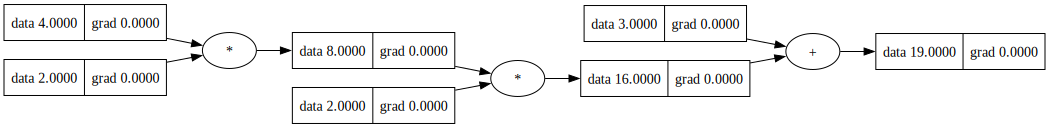

In [64]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

draw_dot(f)

In [65]:
# Пройдем по этому графу в обратную сторону и попробуем численно посчитать градиенты

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

In [66]:
# Производная числа по какому-либо параметру - это то, как изменится число при изменении этого параметра на малую величину,
# при неизменных остальных параметрых

In [67]:
# Найдем производную df/df

In [75]:
def lol():
    h = 0.0001
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f1 = e * l
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f2 = e * l
    f2.data += h
    
    print((f2.data-f1.data)/h)

lol()

0.9999999999976694


In [39]:
# Нетрудно понять, что производная переменной по самой себе это 1, попробуем найти таким образом производные по df по всем остальным переменным

In [76]:
def lol():
    h = 0.0001
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f1 = e * l
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    e.data += h
    l = Value(3.0)
    f2 = e * l
    
    print((f2.data-f1.data)/h)

lol()

2.9999999999930083


In [70]:
# Нетрудно увидеть, что дифференцируя выражение f = e * l по l или по e, мы получим e или l соответственно, но как посчитать производную по a, b, j ,d?
# Здесь нам поможет правило производной сложной функции или правило цепочки

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a610aa8446be002e2e30d7121f6a87273d4caa)

In [51]:
# То есть мы, зная производную dz/dy и найдя производную dy/dx можем легко найти производную dz/dx. Тут z = y(x)
# Сохраним найденные градиенты

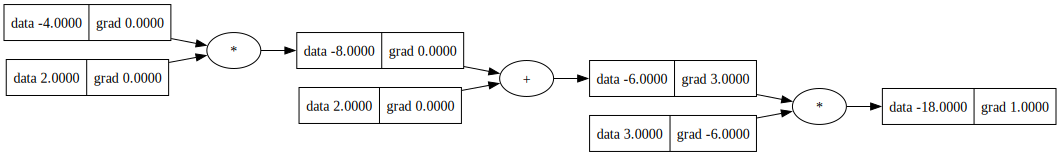

In [77]:
f.grad = 1.0
e.grad = l.data
l.grad = e.data
draw_dot(f)

In [92]:
"""
f = e * l
e = d + j

df/dd ?
df/dd = df/de * de/dd

((e+h)*l - e*l) / h
(e*l + h*l -e*l)/h
h*l/h
l

df/de = l

((d+h) + j - (d + j)) / h
(d + h + j - d - j) / h
h / h
1

de/dd = 1

df/dd = l * 1
l = 3
df/dd = 3

Проверим
""";

In [93]:
# df/dd
def lol():
    h = 0.0001
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f1 = e * l
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    d.data += h
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f2 = e * l
    
    print((f2.data-f1.data)/h)

lol()

2.9999999999930083


In [86]:
# Аналогично для df/dj, запишем градиенты

In [100]:
d.grad = 3
j.grad = 3

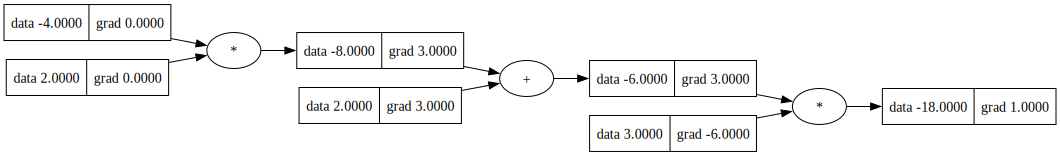

In [89]:
draw_dot(f)

In [91]:
"""
df/da ?
df/da = df/de * de/dd * dd/da

Мы уже знем df/de * de/dd, на этом этапе нам необходимо только знать dd/da
d = a * b
((a+h)*b - a*b) / h
(a*b + h*b -a*b)/h
h*b/h
b

dd/da = b
df/de = l
de/dd = 1

df/da = l * 1 * b
l = 3
b = -4
df/da = -12

Проверим
""";

In [97]:
# df/da
def lol():
    h = 0.0001
    
    a = Value(2.0)
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f1 = e * l
    
    a = Value(2.0)
    a.data += h
    b = Value(-4.0)
    d = a * b
    j = Value(2.0)
    e = d + j
    l = Value(3.0)
    f2 = e * l
    
    print((f2.data-f1.data)/h)

lol()

-12.000000000043087


In [95]:
# Аналогично для b

In [101]:
a.grad = -12
b.grad = 6

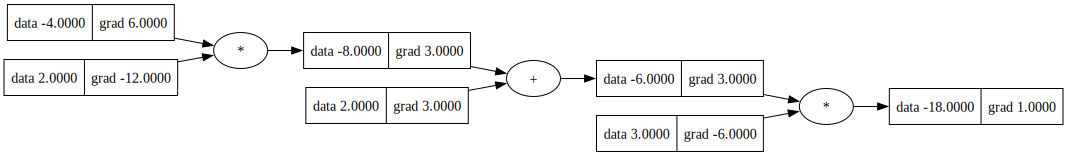

In [102]:
draw_dot(f)

In [103]:
# Итого получается, что нам необходимо знать всего лишь локальную производную и производную пришедшую выше по графу
# Как можно автоматизировать подсчет градиентов?

In [104]:
# Добавим функции для простых ячеек для подсчета градиентов и функцию для обхода всего графа и подсчета градиентов в нем

In [561]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._children = set(_children)
        self._op = _op
        
        self.grad = 0.0
        self._backward = lambda: None  # функция, которая будет считать локальные производные

    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data+other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data*other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data**other.data, (self, other), f'**{other.data}')
        
        def _backward():
            self.grad += out.grad * (other.data * self.data ** (other.data-1))
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data<0 else self.data, (self, ), 'relu')
        
        def _backward():
            self.grad += out.grad if out.data > 0 else 0
        out._backward = _backward
        return out

    def tanh(self):
        e_2x = math.exp(2*self.data)
        tanh = (e_2x - 1) / (e_2x + 1)
        out = Value(tanh, (self, ), 'tanh')
        
        def _backward():
            self.grad += out.grad * (1 - tanh**2)
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0  # производная по самому себе 1
        
        visited = set()
        path = []
        # надо обойти граф, при этом считать градиенты сначала у более верхних нод, а затем только у более нижних
        def build_path(root):
            if root not in visited:
                visited.add(root)
                for child in root._children:
                    build_path(child)
                path.append(root)
                    
        build_path(self)
        for v in reversed(path):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [562]:
a = Value(2.0)
b = Value(-4.0)
d = a * b
j = Value(2.0)
e = d + j
l = Value(3.0)
f = e * l
r = a * f + d
q = b * j + e ** j
e = q.relu()

In [563]:
e.backward()

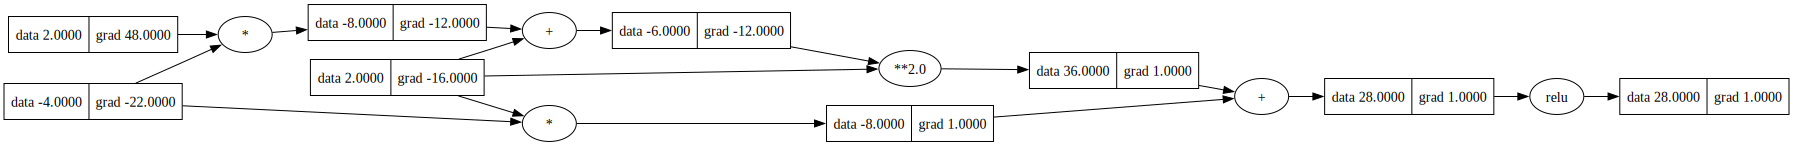

In [564]:
draw_dot(e)

In [565]:
a = Value(2.0)
b = Value(-4.0)
d = a * b
j = Value(-2.0)
e = d + j
l = Value(5.0)
f = e * l
r = a * f + d
i = Value(7)
q = b * j - e ** j - i
e = q.tanh()

In [566]:
e.backward()

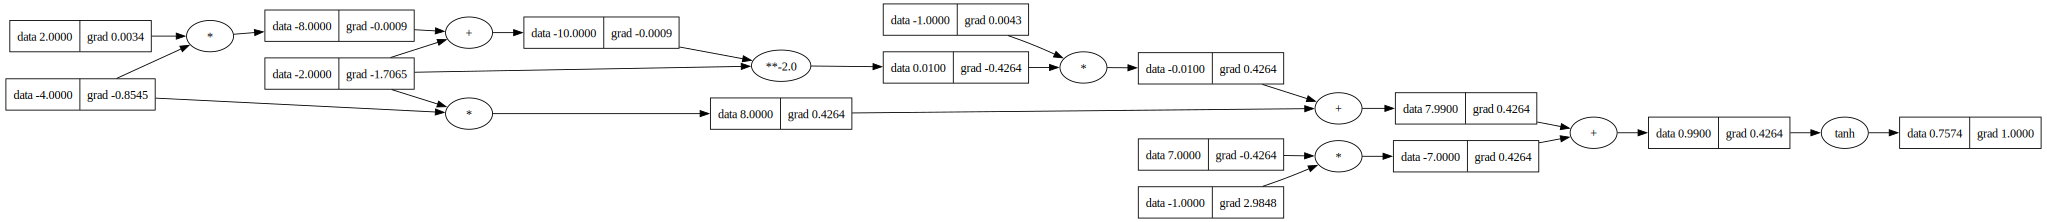

In [567]:
draw_dot(e)

In [568]:
# Создадим класс для нейрона

In [597]:
class Neuron:
    def __init__(self, nin, activation=False):
        self.weight = [Value(np.random.random()) for _ in range(nin)]
        self.bias = Value(0)

        self.activation = activation

    def __call__(self, x):
        act = sum([x_i*w_i for x_i, w_i in zip(x, self.weight)], self.bias)
        return act.tanh() if self.activation else act

    def parameters(self):
        return self.weight + [self.bias]

    def __repr__(self):
        return f"Neuron(nin={len(self.weight)}, activation={self.activation})"

In [598]:
sample_x = [0.4, 6.2, -1.8]
neuron = Neuron(3, True)
neuron

Neuron(nin=3, activation=True)

In [599]:
out = neuron(sample_x)

In [600]:
neuron.parameters()

[Value(data=0.5546091126573505, grad=0.0),
 Value(data=0.4085421802690675, grad=0.0),
 Value(data=0.3186995593432628, grad=0.0),
 Value(data=0, grad=0.0)]

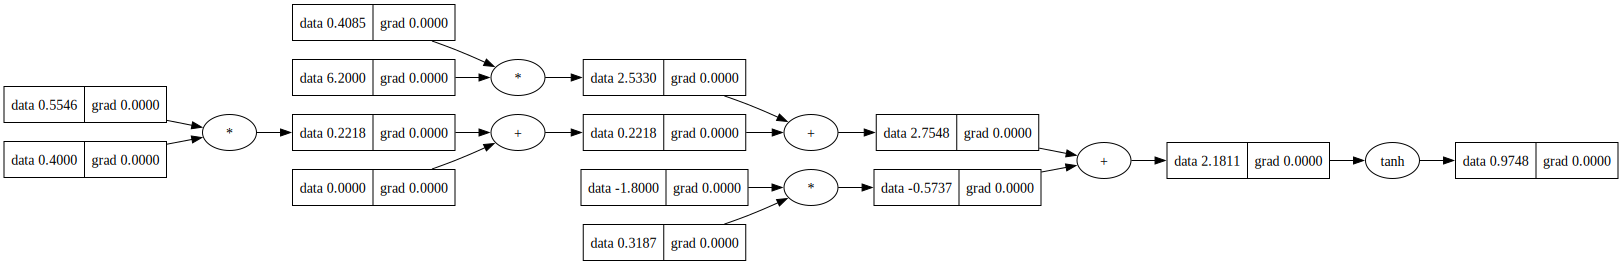

In [601]:
draw_dot(out)

In [602]:
# Теперь можем создать слой нейронов

In [603]:
class Linear:
    def __init__(self, nin, nout, **kwargs):
        self.nin = nin
        self.nout = nout
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        act = [n(x) for n in self.neurons]
        return act[0] if len(self.neurons) == 1 else act

    def parameters(self):
        parameters = []
        for n in self.neurons:
            parameters.extend(n.parameters())
        return parameters

    def __repr__(self):
        return f"Linear(nin={self.nin}, nout={self.nout})"

In [604]:
linear = Linear(3, 4, activation=True)

In [605]:
out = linear(sample_x)

In [606]:
out

[Value(data=0.9997578545278898, grad=0.0),
 Value(data=0.9999671272125779, grad=0.0),
 Value(data=0.999988766148351, grad=0.0),
 Value(data=0.9999695846750623, grad=0.0)]

In [607]:
# Теперь из этого можно собрать небольшую сеть

In [608]:
class NeuralNetwork:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Linear(sizes[i], sizes[i+1], activation=i!=len(sizes)-2) for i in range(len(sizes)-1)]

    def __call__(self, x):
        _input = x
        for layer in self.layers:
            _input = layer(_input)
        return _input

    def parameters(self):
        parameters = []
        for n in self.layers:
            parameters.extend(n.parameters())
        return parameters

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def __repr__(self):
        return "Input-> " + " -> ".join([str(layer) for layer in self.layers])

In [609]:
mlp = NeuralNetwork(3, [4, 4, 1])

In [610]:
mlp

Input-> Linear(nin=3, nout=4) -> Linear(nin=4, nout=4) -> Linear(nin=4, nout=1)

In [611]:
# draw_dot(mlp(sample_x))

In [636]:
# Небольшой набор данных для теста обучения сети

In [612]:
x_sample = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y_sample = [1.0, -1.0, -1.0, 1.0]

In [613]:
y_pred = [mlp(x) for x in x_sample]
y_pred

[Value(data=1.9509950987219513, grad=0.0),
 Value(data=1.9394155336509051, grad=0.0),
 Value(data=1.9514535362210055, grad=0.0),
 Value(data=1.1430197360474703, grad=0.0)]

In [637]:
# Запишем MSE loss без усреднения

In [614]:
loss = sum([(y_t - y_p)**2 for y_t, y_p in zip(y_sample, y_pred)])
loss

Value(data=18.276087978631978, grad=0.0)

In [638]:
# В результате получаем уже знакомый объект Value, по которому можно искать градиенты

In [615]:
loss.backward()

In [616]:
mlp.parameters()

[Value(data=0.4878571725457166, grad=0.48384235636599154),
 Value(data=0.7133637581502358, grad=0.012467871770561578),
 Value(data=0.3817693038318495, grad=0.03034084954163084),
 Value(data=0, grad=0.2592671798374229),
 Value(data=0.45638861538147446, grad=0.7225189413949509),
 Value(data=0.43351849777317, grad=0.31740208682857934),
 Value(data=0.774431259308868, grad=-0.17633121543460362),
 Value(data=0, grad=0.5019203068639811),
 Value(data=0.8787109775238223, grad=0.16587844226170168),
 Value(data=0.7175097486684995, grad=0.12466855173137108),
 Value(data=0.7698267807468201, grad=-0.08600685938186668),
 Value(data=0, grad=0.14978921700544998),
 Value(data=0.3906891110093046, grad=0.8456860841955731),
 Value(data=0.430755971421136, grad=0.3368708298752908),
 Value(data=0.934251035654106, grad=-0.20234014868693365),
 Value(data=0, grad=0.5435417159433856),
 Value(data=0.47483730921950995, grad=0.7829905987979365),
 Value(data=0.7737438306144128, grad=0.7166359120852412),
 Value(data=0

In [617]:
# draw_dot(loss)

In [643]:
# Так как у нас на каждой итерации идет накопление градиентов, надо их обнулять

In [641]:
mlp = NeuralNetwork(3, [4, 4, 1])

for n in range(50):
    # forward pass
    y_pred = [mlp(x) for x in x_sample]
    loss = sum([(y_t - y_p)**2 for y_t, y_p in zip(y_sample, y_pred)])

    # backward pass
    mlp.zero_grad()
    loss.backward()
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    print(n, loss.data)

0 8.672517648457417
1 5.6191187948404755
2 4.557314468467055
3 4.218777520032653
4 4.1079220566616135
5 4.060138720289765
6 4.033792725590663
7 4.015191634476433
8 3.9995508181017305
9 3.9848227145008286
10 3.96984324112973
11 3.9537192707314865
12 3.9355331193922356
13 3.9141545524906283
14 3.8880342412050215
15 3.8548932112413015
16 3.8112306250597503
17 3.7514722364679045
18 3.6665146147388334
19 3.541024275898322
20 3.3469832239713537
21 3.020939176748071
22 2.4110212442366756
23 1.5233716711701963
24 0.8140925111954728
25 0.40234708750166553
26 0.19786439478933968
27 0.10611041052212682
28 0.06670662186506249
29 0.049174194097926706
30 0.040304166810933004
31 0.034878475692160085
32 0.03093603445841967
33 0.027742688261660427
34 0.025010497343036193
35 0.02261259156527016
36 0.020482288301188797
37 0.01857733133462849
38 0.01686695212051693
39 0.015326841248513707
40 0.013936952795925132
41 0.01268036813176075
42 0.01154260509946086
43 0.010511142853334788
44 0.009575070976267343


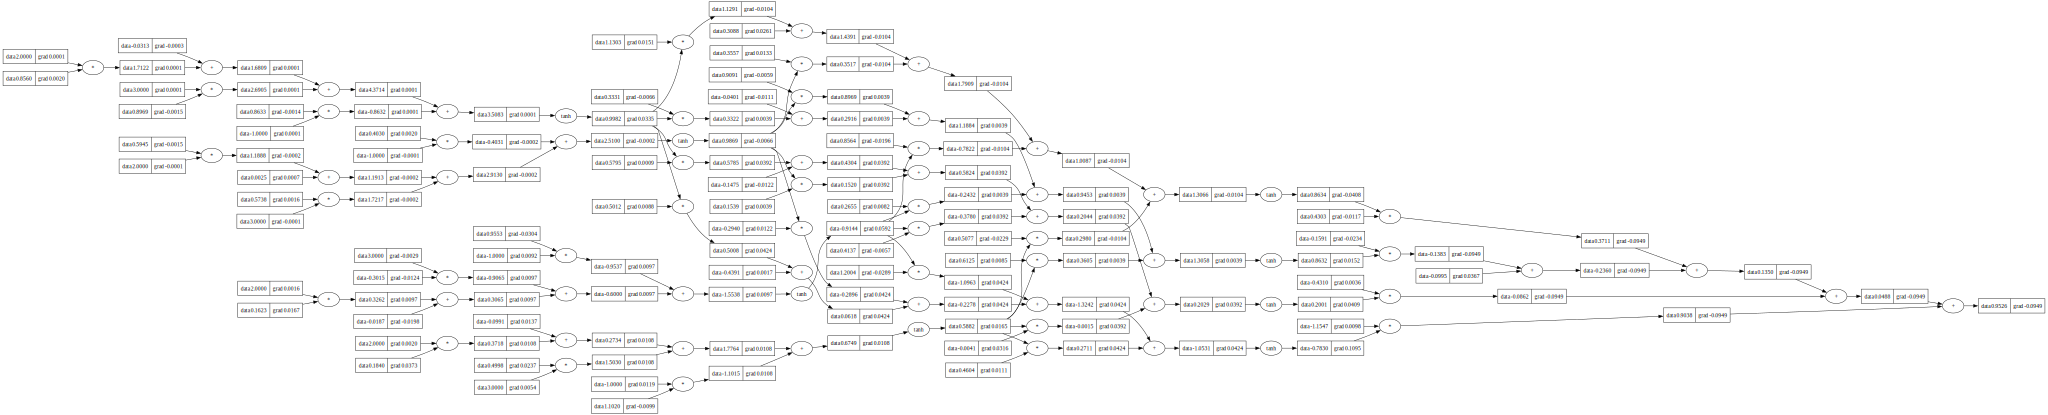

In [642]:
draw_dot(y_pred[0])

In [621]:
import torch

In [622]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

In [623]:
test_sanity_check()

In [632]:
def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    print(g)
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    print(g)
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    print(amg.grad, apt.grad.item())
    print(bmg.grad, bpt.grad.item())
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [633]:
test_more_ops()

Value(data=24.70408163265306, grad=1.0)
tensor([24.7041], dtype=torch.float64, grad_fn=<AddBackward0>)
138.83381924198252 138.83381924198252
645.5772594752187 645.5772594752186
